In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
# 데이터 읽기
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct) # 샘플수

In [3]:
# 입력 데이터
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

In [4]:
# 정답 데이터 원핫 인코딩
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

In [18]:
# 훈련 데이터, 테스트 데이터
index = np.arange(n_data)
index_train = index[index % 2 == 0]
index_test = index[index % 2 != 0]

input_train = input_data[index_train, :]
correct_train = correct_data[index_train, :]
input_test = input_data[index_test, :]
correct_test = correct_data[index_test, :]

n_train = input_train.shape[0]  # 훈련 데이터 수
n_test = input_test.shape[0]

In [19]:
# 하이퍼 파라미터
n_in = 4
n_mid = 25
n_out = 3

wb_width = 0.1   # 표준편차
eta = 0.01   # 학습률
epoch = 1000
batch_size = 8
interval = 100  # 경과표시

In [20]:
# 부모 class
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

In [31]:
# 은닉층
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)  # ReLU
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis = 0)
        
        self.grad_x = np.dot(delta, self.w.T)

In [22]:
# 출력층
class OutputLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        # 소프트맥스
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis = 0)
        
        self.grad_x = np.dot(delta, self.w.T)

In [32]:
middle_layer_1 = MiddleLayer(n_in, n_mid)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
output_layer = OutputLayer(n_mid, n_out)

In [33]:
# 순전파
def forward_propagation(x):
    middle_layer_1.forward(x)
    middle_layer_2.forward(middle_layer_1.y)
    output_layer.forward(middle_layer_2.y)

In [34]:
# 역전파
def backpropagation(t):
    output_layer.backward(t)
    middle_layer_2.backward(output_layer.grad_x)
    middle_layer_1.backward(middle_layer_2.grad_x)

In [35]:
# 가중치, 편향 수정
def uppdate_wb():
        middle_layer_1.update(eta)
        middle_layer_2.update(eta)
        output_layer.update(eta)

In [36]:
# 교차 엔트로피 오차 계산
def get_error(t, batch_size):
    return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size

In [37]:
# 오차 기록
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

In [38]:
# 학습 경과 기록
n_batch = n_train // batch_size # 1에포크당 배치 수
for i in range(epoch):
    # 오차 계측
    forward_propagation(input_train)
    error_train = get_error(correct_train, n_train)
    forward_propagation(input_test)
    error_test = get_error(correct_test, n_test)
    
    # 오차 기록
    test_error_x.append(i)
    test_error_y.append(error_test)
    train_error_x.append(i)
    train_error_y.append(error_train)
    
    # 경과 표시
    if i % interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
             "Error_train:" + str(error_train),
             "Error_test:" + str(error_test))
        
    # 학습
    index_random = np.arange(n_train)
    np.random.shuffle(index_random)
    
    for j in range(n_batch):
        # 미니배치 샘플 추출
        mb_index = index_random[j * batch_size : (j+1) * batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        # 순전파, 역전파
        forward_propagation(x)
        backpropagation(t)
        
        # 가중치, 편향 수정
        uppdate_wb()

Epoch:0/1000 Error_train:1.0898629165225502 Error_test:1.087532415744417
Epoch:100/1000 Error_train:0.031365069030474334 Error_test:0.08110007338824955
Epoch:200/1000 Error_train:0.014855051006490448 Error_test:0.07719507066550739
Epoch:300/1000 Error_train:0.009914446891527842 Error_test:0.09810398270520243
Epoch:400/1000 Error_train:0.004851302610555925 Error_test:0.1228736634241076
Epoch:500/1000 Error_train:0.0027206346749172653 Error_test:0.1432648211590294
Epoch:600/1000 Error_train:0.001792809416314769 Error_test:0.16050704547595507
Epoch:700/1000 Error_train:0.0012022966835506406 Error_test:0.17410242676246585
Epoch:800/1000 Error_train:0.0009007951084752985 Error_test:0.18516075775487445
Epoch:900/1000 Error_train:0.0007123742627702231 Error_test:0.1944041898755751


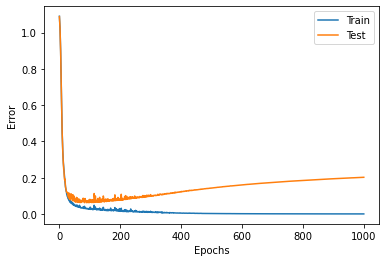

In [39]:
plt.plot(train_error_x, train_error_y, label = "Train")
plt.plot(test_error_x, test_error_y, label = "Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# 에포크를 늘리면 과적합 일어남

In [42]:
# 정답률
forward_propagation(input_train)
count_train = np.sum(np.argmax(output_layer.y, axis = 1) == 
                    np.argmax(correct_train, axis = 1))

forward_propagation(input_test)
count_test = np.sum(np.argmax(output_layer.y, axis = 1) ==
                   np.argmax(correct_test, axis = 1))

print("Accuracy Train:", str(count_train/n_train * 100) + "%",
     "Accuracy Test:", str(count_test/n_test * 100) + "%")

Accuracy Train: 100.0% Accuracy Test: 96.0%


In [43]:
# 과적합 대책 : 최적화 알고리즘 : SGD -> AdaGrad, 드롭아웃 적용

In [46]:
# AdaGrad사용을 위한 class수정
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)
        
        self.h_w = np.zeros((n_upper, n) + 1e-8)
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

In [45]:
# 드롭아웃 구현
class Dropout:
    def __init__(self, dropout_ratio):
        self.dropout_ratio = dropout_ratio  # 드롭 확률
        
    def forward(self, x, is_train):
        if is_train:  # 훈련때만 작동
            rand = np.random.rand(*x.shape)  # 난수
            self.dropout = np.where(rand > self.dropout_ratio, 1, 0)
            self.y = x * self.dropout
        else:
            self.y = (1-self.dropout_ratio) * x
            
    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout

In [47]:
# 드롭아웃을 추가한 신경망

# 초기화
middle_layer_1 = MiddleLayer(n_in, n_mid)
dropout_1 = Dropout(0.5)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
dropout_2 = Dropout(0.5)
output_layer = OutputLayer(n_mid, n_out)

# 순전파
def forward_propagation(x, is_train):
    middle_layer_1.forward(x)
    dropout_1.forward(middle_layer_1.y, is_train)
    middle_layer_2.forward(dropout_1.y)
    dropout_2.forward(middle_layer_2.y, is_train)
    output_layer.forward(dropout_2.y)
    
# 역전파
def backpropagation(t):
    output_layer.backward(t)
    dropout_2.backward(output_layer.grad_x)
    middle_layer_2.backward(dropout_2.grad_x)
    dropout_1.backward(middle_layer_2.grad_x)
    middle_layer_1.backward(dropout_1.grad_x)

Epoch:0/1000 Error_train:0.013218182512181282 Error_test:0.9160799483301023
Epoch:100/1000 Error_train:0.06466885878440146 Error_test:0.8677423512040032
Epoch:200/1000 Error_train:0.010499324493832847 Error_test:0.9353221114900175
Epoch:300/1000 Error_train:0.003761721931212673 Error_test:0.9233583918873952
Epoch:400/1000 Error_train:0.023671168812581515 Error_test:0.9367580842835999
Epoch:500/1000 Error_train:0.0054451376657501886 Error_test:0.8749493740389183
Epoch:600/1000 Error_train:0.007518254624212764 Error_test:0.9530127894702012
Epoch:700/1000 Error_train:0.006676252745466562 Error_test:0.8885866315052503
Epoch:800/1000 Error_train:0.0036214853279071947 Error_test:0.8963562653629862
Epoch:900/1000 Error_train:0.016817112366468587 Error_test:0.8856251977935237


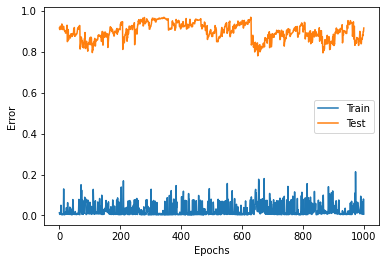

Accuracy Train: 100.0% Accuracy Test: 97.33333333333334%


In [54]:
# 오차 기록
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

# 학습 경과 기록
n_batch = n_train // batch_size # 1에포크당 배치 수
for i in range(epoch):
    # 오차 계측
    forward_propagation(input_train, True)
    error_train = get_error(correct_train, n_train)
    forward_propagation(input_test, False)
    output_layer.y = output_layer.y * 0.5
    error_test = get_error(correct_test, n_test)
    
    # 오차 기록
    test_error_x.append(i)
    test_error_y.append(error_test)
    train_error_x.append(i)
    train_error_y.append(error_train)
    
    # 경과 표시
    if i % interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
             "Error_train:" + str(error_train),
             "Error_test:" + str(error_test))
        
    # 학습
    index_random = np.arange(n_train)
    np.random.shuffle(index_random)
    
    for j in range(n_batch):
        # 미니배치 샘플 추출
        mb_index = index_random[j * batch_size : (j+1) * batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        # 순전파, 역전파
        forward_propagation(x, True)
        backpropagation(t)
        
        # 가중치, 편향 수정
        uppdate_wb()
        
plt.plot(train_error_x, train_error_y, label = "Train")
plt.plot(test_error_x, test_error_y, label = "Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# 에포크를 늘리면 과적합 일어남

# 정답률
forward_propagation(input_train, True)
count_train = np.sum(np.argmax(output_layer.y, axis = 1) == 
                    np.argmax(correct_train, axis = 1))

forward_propagation(input_test, False)
count_test = np.sum(np.argmax(output_layer.y, axis = 1) ==
                   np.argmax(correct_test, axis = 1))

print("Accuracy Train:", str(count_train/n_train * 100) + "%",
     "Accuracy Test:", str(count_test/n_test * 100) + "%")